# zerofa

**Deliverable** An application that reduces fatalities and serious injuries from vehicle accidents by raising driver awareness of potential dangers and recommending appropriate responses. Dangers could be predicted by road function (interstate, collector, etc.), area (urban vs. rural), configuration (4-way stop, right hand curve, etc).

**Scope**  United States only. Ignores well known factors, such as driving under the influence, speeding, etc. to focus on environmental and behavioral factors.

**Data** Detailed accident data from the Fatality Accident Reporting System FARS managed by the U.S. National Highway Traffic Safety Administration NHTSA. Data are available for the years 1975-2014 as dBase and SAS files.

### Import and Setup

In [374]:
import math
import numpy as np
import os
import pandas as pd
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.misc
import zipfile
from ftplib import FTP

%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

### Classes and functions

In [2]:
def clean_excel(excel_file, first_value, last_value):
    print 'working with file {ef}'.format(ef=excel_file)
    with pd.ExcelFile(excel_file) as excel:
        try:
            df = excel.parse(str(excel.sheet_names[0]))
            print 'trying sheet {sn}'.format(sn=str(excel.sheet_names[0])) 
            first_row = df.index[df.iloc[:,0].str.contains(first_value)==True][0]
            last_row = df.index[df.iloc[:,0].str.contains(last_value)==True][0]
        except:
            df = excel.parse(str(excel.sheet_names[1]))
            first_row = df.index[df.iloc[:,0].str.contains(first_value)==True][0]
            last_row = df.index[df.iloc[:,0].str.contains(last_value)==True][0]
            print 'switched to sheet {sn}'.format(sn=str(excel.sheet_names[1]))
    print 'finished parsing'
    main_df = df.iloc[first_row:last_row+1]
    extra_df = df.iloc[last_row+2:last_row+3]
    full_df = pd.concat([main_df, extra_df], ignore_index=True)
    return full_df 

In [3]:
def get_column_names(excel_file, first_value):
    with pd.ExcelFile(excel_file) as excel:
        try:
            df = excel.parse(str(excel.sheet_names[0]))
            print 'Trying {sn}'.format(sn=str(excel.sheet_names[0])) 
            first_row = df.index[df.iloc[:,0].str.contains(first_value)==True][0]
        except:
            df = excel.parse(str(excel.sheet_names[1]))
            first_row = df.index[df.iloc[:,0].str.contains(first_value)==True][0]
            print 'Switched to {sn}'.format(sn=str(excel.sheet_names[1]))
    names = df.iloc[:first_row].apply(lambda x: ''.join(str(x).strip()))
    print names
    new_names = []
    for name in names:
        new_name = re.sub('NaN\s*','', name)
        new_name = re.sub('Name: (Unnamed:)? (\d+)?, dtype: object','', new_name)
        new_name = re.sub('\d+\s{4}\s*','', new_name)
        new_name = re.sub('\\n', ' ', new_name)
        new_name = re.sub(' \d?\/ ?', '', new_name)
        new_name = re.sub(' $', '', new_name)
        new_names.append(new_name)
        new_names[0] = re.findall('\w+$', new_names[0])[0]
        new_names[len(new_names)-1] = re.sub('^TABLE [^ ]* ', '', 
                                            new_names[len(new_names)-1])
    print new_names
    return new_names

In [4]:
def clean_unicode(df_column):
    df_column = df_column.apply(lambda x: x.decode('unicode_escape').encode('ascii', 'ignore').strip())
    return df_column

### Get Data
Accident data available from ftp.nhtsa.dot.gov. Zipped DBF files (FoxPro, xBase, *etc*. database format) are in `fars\DBF` folders.

#### Retrieve from ftp

#### Fatality Analysis Reporting System FARS data

In [5]:
yrs = range(2010, 2015)

In [6]:
table_files = ('accident', 'cevent', 'person', 'vehicle')
for y in yrs:
    ftp = FTP('ftp.nhtsa.dot.gov')
    ftp.login('anonymous','jonathan.owen@msn.com')
    ftp.cwd('fars/%s/DBF' % y)
    f = 'FARS%s.zip' % y
    with open('data/%s' % f, 'wb') as outfile:
        ftp.retrbinary('RETR %s' % f, outfile.write)

#### General Estimate System GES data

In [7]:
for y in yrs:
    ftp = FTP('ftp.nhtsa.dot.gov')
    ftp.login('anonymous','jonathan.owen@msn.com')
    ftp.cwd('GES/GES{y2}'.format(y2=str(y)[2:4]))
    try:
        f = 'GES{y2}_Flatfile.zip'.format(y2=str(y)[2:4])
        with open('data/{yd}/{fn}'.format(yd=str(y), fn=f), 'wb') as outfile:
            ftp.retrbinary('RETR {fn}'.format(fn=f), outfile.write)
    except:
        f = 'GES{y4}flat.zip'.format(y4=str(y))
        with open('data/{yd}/{fn}'.format(yd=str(y), fn=f), 'wb') as outfile:
            ftp.retrbinary('RETR {fn}'.format(fn=f), outfile.write)
    ftp.close()

#### Unzip to data/year directories

In [7]:
for y in yrs:
    with zipfile.ZipFile('data/FARS%s.zip' % y, 'r') as z:
        z.extractall('/home/vagrant/fars/data/%s' % y)

#### Read tables from CSV and TXT files

In [8]:
table_files = ('accident', 'cevent', 'person', 'vehicle')

In [9]:
fars, ges = {},{}
for tf in table_files:
    frames_fars, frames_ges = [],[]
    for y in yrs:
        with open('/home/vagrant/fars/data/csv/{yr}/{tb}.csv'\
                  .format(yr=y, tb=tf),'r') as f:
            frames_fars.append(pd.read_csv(f))
        if y == 2010:
            dt='TXT/{tb}'.format(tb=tf.upper())
        else:
            dt=tf.upper()
        try:
            with zipfile.ZipFile('data/{yd}/GES{y2}_Flatfile.zip'\
                                 .format(yd=str(y),y2=str(y)[2:4]),'r') as z: 
                frames_ges.append(pd.read_table(z.open('{tn}.TXT'\
                                                       .format(tn=dt))))
        except:
            with zipfile.ZipFile('data/{yd}/GES{y4}flat.zip'\
                                 .format(yd=str(y),y4=str(y)),'r') as z:
                frames_ges.append(pd.read_table(z.open('{tn}.TXT'\
                                                      .format(tn=dt))))
    fars[tf], ges[tf] = frames_fars, frames_ges

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,20,21,22,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,20,21,22,29,30,32,33,36,37,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=c

In [10]:
fars

{'accident': [       STATE  ST_CASE  VE_TOTAL  VE_FORMS  PEDS  PERSONS  COUNTY  CITY  DAY  \
  0          1    10001         1         1     0        2      81  2340   15   
  1          1    10002         1         1     0        1      35  1080   11   
  2          1    10003         3         3     0        3      97  2100   14   
  3          1    10004         2         2     0        2     115   160   21   
  4          1    10005         2         2     0        2     117     0    4   
  5          1    10006         1         1     0        1      21     0    1   
  6          1    10007         1         1     0        2      97     0    1   
  7          1    10008         1         1     0        4       9     0    2   
  8          1    10009         1         1     0        2      51     0    2   
  9          1    10010         2         2     0        4     113     0    3   
  10         1    10011         1         1     0        1      95     0    4   
  11         1  

#### Import XLS and XLSX files
#### Get file names from directory and create dataframe of details

In [11]:
excel_path = '/home/vagrant/fars/data/xlsx'
excel_files = os.listdir(excel_path)
excels = pd.DataFrame(data=excel_files, columns=['filename'])
file_year = []
source_table = []
description = []
full_path = []
for e in excels.filename:
    file_year.append(re.findall('(\d{4}).xlsx?$', e)[0])
    source_table.append(re.findall('_([^_]*)_\d{4}.xlsx?$', e)[0])
    description.append(re.findall('^(\w+)_[^_]*_\d{4}.xlsx?$', e)[0])
    full_path.append('{ep}/{fn}'.format(ep=excel_path, fn=e))
excels['year'] = file_year
excels['source_table'] = source_table
excels['description'] = description
excels['full_path'] = full_path

#### Create dictionary of data frames for imported data

In [12]:
excel_dict = {}
for i in range(excels.shape[0]):
    i_df = clean_excel(excels.full_path[i], 'Alabama', 'Wyoming')
    i_df['FILE_YEAR'] = excels.year[i]
    df_name =  excels.source_table[i]
    if excel_dict.has_key(df_name):
        frames = [i_df, excel_dict[df_name]]
        excel_dict[df_name] = pd.concat(frames) 
    else:
        excel_dict[df_name] = i_df

Sending file /home/vagrant/fars/data/xlsx/vehicle_reg_by_state_mv1_2014.xlsx
working with file /home/vagrant/fars/data/xlsx/vehicle_reg_by_state_mv1_2014.xlsx
trying sheet 2014 Final 
finished parsing
mv1
creating mv1 dataframe as new item
Sending file /home/vagrant/fars/data/xlsx/vehicle_miles_distribution_vm4_2010.xls
working with file /home/vagrant/fars/data/xlsx/vehicle_miles_distribution_vm4_2010.xls
trying sheet A
finished parsing
vm4
creating vm4 dataframe as new item
Sending file /home/vagrant/fars/data/xlsx/lane_length_by_function_hm60_2013.xls
working with file /home/vagrant/fars/data/xlsx/lane_length_by_function_hm60_2013.xls
trying sheet CRYSTAL_PERSIST
switched to sheet A
finished parsing
hm60
creating hm60 dataframe as new item
Sending file /home/vagrant/fars/data/xlsx/vehicle_reg_by_state_mv1_2011.xlsx
working with file /home/vagrant/fars/data/xlsx/vehicle_reg_by_state_mv1_2011.xlsx
trying sheet MV-1
finished parsing
mv1
adding 52 rows to mv1
new shape = (104, 17)
Sendin

#### Melt vehicle miles table

In [13]:
vm2_full = excel_dict['vm2']
road_function_upper = ['INTERSTATE', 'FREEWAY OR EXPRESSWAY',
                      'OTHER PRINCIPAL ARTERIAL', 'MINOR ARTERIAL',
                      'MAJOR COLLECTOR', 'MINOR COLLECTOR', 'LOCAL']
road_function_only = []
for rf in road_function_upper:
    rf = rf.lower()
    rf = re.sub(' ', '_', rf)
    road_function_only.append(rf)
for i in range(1, 8):
    df_rural = vm2_full.loc[:,['FILE_YEAR', 'Unnamed: 0', 'Unnamed: {n}'.format(n=i)]]
    df_rural.columns = ['year', 'state', 'vehicle_miles']
    df_rural['road_area'] = 'rural'
    df_rural['road_function_only'] = road_function_only[i-1]
    df_urban = vm2_full.loc[:,['FILE_YEAR', 'Unnamed: 0', 'Unnamed: {n}'.format(n=i+8)]]
    df_urban.columns = ['year', 'state', 'vehicle_miles']
    df_urban['road_area'] = 'urban'
    df_urban['road_function_only'] = road_function_only[i-1]
    
    if i == 1:
        vm2_melt = pd.concat([df_rural, df_urban], ignore_index=True, axis=0)
    else:
        vm2_melt = pd.concat([vm2_melt, df_rural, df_urban], ignore_index=True, axis=0)
vm2_melt['year'] = pd.to_numeric(vm2_melt['year'])
vm2_melt['state'] = clean_unicode(vm2_melt['state'])
vm2_melt['road_area'] = clean_unicode(vm2_melt['road_area'])
vm2_melt['road_function_only'] = clean_unicode(vm2_melt['road_function_only'])
road_function_xref = vm2_melt.road_function_only.copy()
vm2_melt['road_function_xref'] = road_function_xref
vm2_melt.loc[((vm2_melt['road_function_xref'] == 'minor_collector')|(vm2_melt['road_function_xref'] == 'major_collector'))&
         (vm2_melt['road_area'] == 'urban'),'road_function_xref'] = 'collector'
vm2 =vm2_melt.groupby(['state', 'year', 'road_area','road_function_xref'],as_index=False)['vehicle_miles'].sum()

In [13]:
vm2

,state,year,road_area,road_function_xref,vehicle_miles
0,Alabama,2010,rural,freeway_or_expressway,0.000000
1,Alabama,2010,rural,interstate,5744.605837
2,Alabama,2010,rural,local,6851.415000
3,Alabama,2010,rural,major_collector,4983.954972
4,Alabama,2010,rural,minor_arterial,4800.226643
5,Alabama,2010,rural,minor_collector,1685.570000
6,Alabama,2010,rural,other_principal_arterial,6503.179197
7,Alabama,2010,urban,collector,3273.775149
8,Alabama,2010,urban,freeway_or_expressway,591.210765
9,Alabama,2010,urban,interstate,7552.172521


#### Read geographic location code GLC table

In [14]:
with open('//home/vagrant/fars/data/GLCs_for_the_USA_and_DC.txt', 'r') as glc_file:
    glc = pd.read_table(glc_file)

#### Read road function code table

In [15]:
with open('//home/vagrant/fars/data/Road_Function_Codes.txt', 'r') as road_file:
    roads = pd.read_table(road_file, header=None, names=['road_fnc', 'road_function_full'])
roads['road_function_full'] = clean_unicode(roads['road_function_full'])
roads['road_area'] = roads.road_function_full.str.split('-',1).str[0]
roads['road_function_only'] = roads.road_function_full.str.split('-',1).str[1]
roads['road_area'] = roads['road_area'].str.lower()
roads['road_function_only'] = roads['road_function_only'].str.lower()
roads['road_function_only'] =  roads['road_function_only'].str.replace('-| ', '_')
roads['road_function_only'] =  roads['road_function_only'].str.replace('local(_\w+)*', 'local')
roads['road_function_only'] =  roads['road_function_only'].str.replace('unknown(_\w+)*', 'unknown')
roads['road_function_only'] =  roads['road_function_only'].str.replace('(\w+_)*interstate', 'interstate')
roads['road_function_only'] =  roads['road_function_only'].str.replace('(\w+_)*freeways_or_expressways', 'freeway_or_expressway')
roads['road_function_only'] =  roads['road_function_only'].str.replace('(\w+_)*interstate', 'interstate')
roads['road_function_only'] =  roads['road_function_only'].str.replace('(\w+_)?principal_arterial(_\w+)?', 
                                                                       'other_principal_arterial')
roads.loc[roads['road_function_only'].isnull(),'road_function_only'] = 'unknown'

In [16]:
roads

,road_fnc,road_function_full,road_area,road_function_only
0,1,Rural-Principal Arterial-Interstate,rural,interstate
1,2,Rural-Principal Arterial-Other,rural,other_principal_arterial
2,3,Rural-Minor Arterial,rural,minor_arterial
3,4,Rural-Major Collector,rural,major_collector
4,5,Rural-Minor Collector,rural,minor_collector
5,6,Rural-Local Road or Street,rural,local
6,9,Rural-Unknown Rural,rural,unknown
7,11,Urban-Principal Arterial-Interstate,urban,interstate
8,12,Urban-Principal Arterial-Other Freeways or Exp...,urban,freeway_or_expressway
9,13,Urban-Other Principal Arterial,urban,other_principal_arterial


#### Join accident table with vehicle miles

In [237]:
accidents = pd.concat(fars['accident'])

In [238]:
new_index=range(accidents.shape[0])
accidents['new_index']=new_index
accidents.set_index('new_index', drop=True, append=False, inplace=True)

##### some cleanup

In [239]:
for i in range(accidents.shape[0]-1):
    if accidents.ix[i,'STATE'] in [16, 35, 2, 19, 38] and accidents.ix[i,'ROAD_FNC']==12:
            accidents.ix[i, 'ROAD_FNC'] = 13  
    if accidents.ix[i,'STATE']==38 and accidents.ix[i,'ROAD_FNC']==5:
            accidents.ix[i, 'ROAD_FNC'] = 4
    if accidents.ix[i,'STATE']==15 and accidents.ix[i,'ROAD_FNC']==1:
            accidents.ix[i, 'ROAD_FNC'] = 2 

In [240]:
accidents_roads = pd.merge(accidents, roads, how='left',
                           left_on='ROAD_FNC',
                           right_on='road_fnc')
accidents_roads_glc = pd.merge(accidents_roads, glc, how='left',
                               left_on=('STATE', 'CITY', 'COUNTY'), 
                               right_on=('State Code', 'City Code', 'County Code'))
accidents_roads_glc['State Name'] = accidents_roads_glc['State Name'].str.title()
accidents_roads_glc['road_area'] = accidents_roads_glc['road_area'].str.lower()
accidents_roads_glc['road_function_only'] = accidents_roads_glc['road_function_only'].str.lower()
accidents_vm2 = pd.merge(accidents_roads_glc, vm2_melt, how='left',
                        left_on=('State Name', 'YEAR', 'road_area', 'road_function_only'),
                        right_on=('state', 'year', 'road_area', 'road_function_xref'))

In [243]:
accidents_select = ['ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 
                    'DAY', 'DAY_WEEK', 'DRUNK_DR', 'FATALS', 'HARM_EV', 
                   'HOSP_HR', 'HOSP_MN', 'HOUR', 'LATITUDE', 'LGT_COND', 
                   'LONGITUD', 'MAN_COLL', 'MILEPT', 'MINUTE', 'MONTH', 
                   'NHS', 'NOT_HOUR', 'NOT_MIN', 'PEDS', 'PERMVIT', 
                   'PERNOTMVIT', 'PERSONS', 'PVH_INVL', 'RAIL', 'RELJCT1', 
                   'RELJCT2', 'REL_ROAD', 'ROUTE', 'SCH_BUS','SP_JUR',
                   'TWAY_ID', 'TWAY_ID2', 'TYP_INT', 'VE_FORMS', 'VE_TOTAL', 
                   'WEATHER', 'WEATHER1', 'WEATHER2', 'WRK_ZONE', 'YEAR', 
                   'STATE', 'ST_CASE','State Abbreviation', 'state', 'CITY', 
                    'COUNTY', 'City Name/County Name', 'ROAD_FNC', 'road_area', 
                   'road_function_xref', 'vehicle_miles']

In [244]:
accidents_rough = accidents_vm2[accidents_select]

In [245]:
accidents_by_vm = accidents_rough.groupby(['YEAR', 
                                           'state', 
                                           'road_area', 
                                           'road_function_xref'] 
                                           , as_index=False).agg(
                                          {'vehicle_miles': lambda x: sum(x)/sum(x>0),
                                           'FATALS': sum})

In [247]:
# road_area='urban' and road_function_xref='collector' is entered twice so multiply fatalities total by 0.5
accidents_by_vm.loc[(accidents_by_vm['road_area']=='urban') & 
                    (accidents_by_vm['road_function_xref']=='collector'),'FATALS'] = accidents_by_vm['FATALS']*50/100

In [248]:
accidents_by_vm['rate'] = accidents_by_vm['FATALS']/(accidents_by_vm['vehicle_miles']+(accidents_by_vm['vehicle_miles']==0))

In [249]:
road_function_set = set(accidents_by_vm.road_function_xref)
road_function_groups = pd.DataFrame({'road_function_xref':list(road_function_set),
                                     'road_function': ['collector',
                                                       'arterial',
                                                       'arterial', 
                                                       'collector',
                                                       'collector',
                                                       'arterial',
                                                       'local',
                                                       'arterial']})

In [250]:
accidents_by_vm = pd.merge(accidents_by_vm, road_function_groups,
                        left_on=('road_function_xref'),
                        right_on=('road_function_xref'))

In [251]:
accidents_by_vm.loc[accidents_by_vm.shape[0]] = [2015, 'Puerto Rico', 'rural', 'local', 20001, 0,0, 'local']

In [252]:
accidents_by_vm.loc[accidents_by_vm['vehicle_miles']==0,]

,YEAR,state,road_area,road_function_xref,vehicle_miles,FATALS,rate,road_function


In [256]:
accidents_by_vm.rate.max()

0.20942890145481521

In [268]:
accidents_by_vm['log_vehicle_miles']=np.log(accidents_by_vm['vehicle_miles'])
accidents_by_vm['log_fatalities']=np.log(accidents_by_vm['FATALS'])

#### save accidents_by_vm

In [270]:
with open('data/accidents_by_vm.csv', 'w') as avm:
    accidents_by_vm.to_csv(avm)

#### Unzip and read GES tables

In [255]:
"""for y in yrs:
    frames = []
    try:
        with zipfile.ZipFile('data/{yd}/GES{y2}_Flatfile.zip'.format(yd=str(y), y2=str(y)[2:4]), 'r') as z:
            frames.append(pd.read_table(z.open()))
            vehicles = pd.concat(frames)
    except:
        with zipfile.ZipFile('data/{yd}/GES{y4}flat.zip'.format(yd=str(y), y4=str(y), 'r') as z:"""

"for y in yrs:\n    frames = []\n    try:\n        with zipfile.ZipFile('data/{yd}/GES{y2}_Flatfile.zip'.format(yd=str(y), y2=str(y)[2:4]), 'r') as z:\n            frames.append(pd.read_table(z.open()))\n            vehicles = pd.concat(frames)\n    except:\n        with zipfile.ZipFile('data/{yd}/GES{y4}flat.zip'.format(yd=str(y), y4=str(y), 'r') as z:"

## Graphs

### Fatalities vs Vehicle Miles

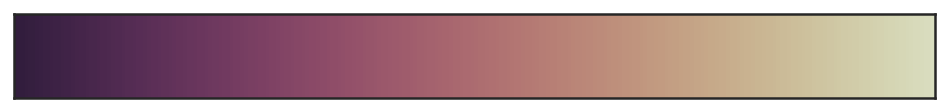

In [392]:
kde_cmap = sns.choose_cubehelix_palette(as_cmap=True)

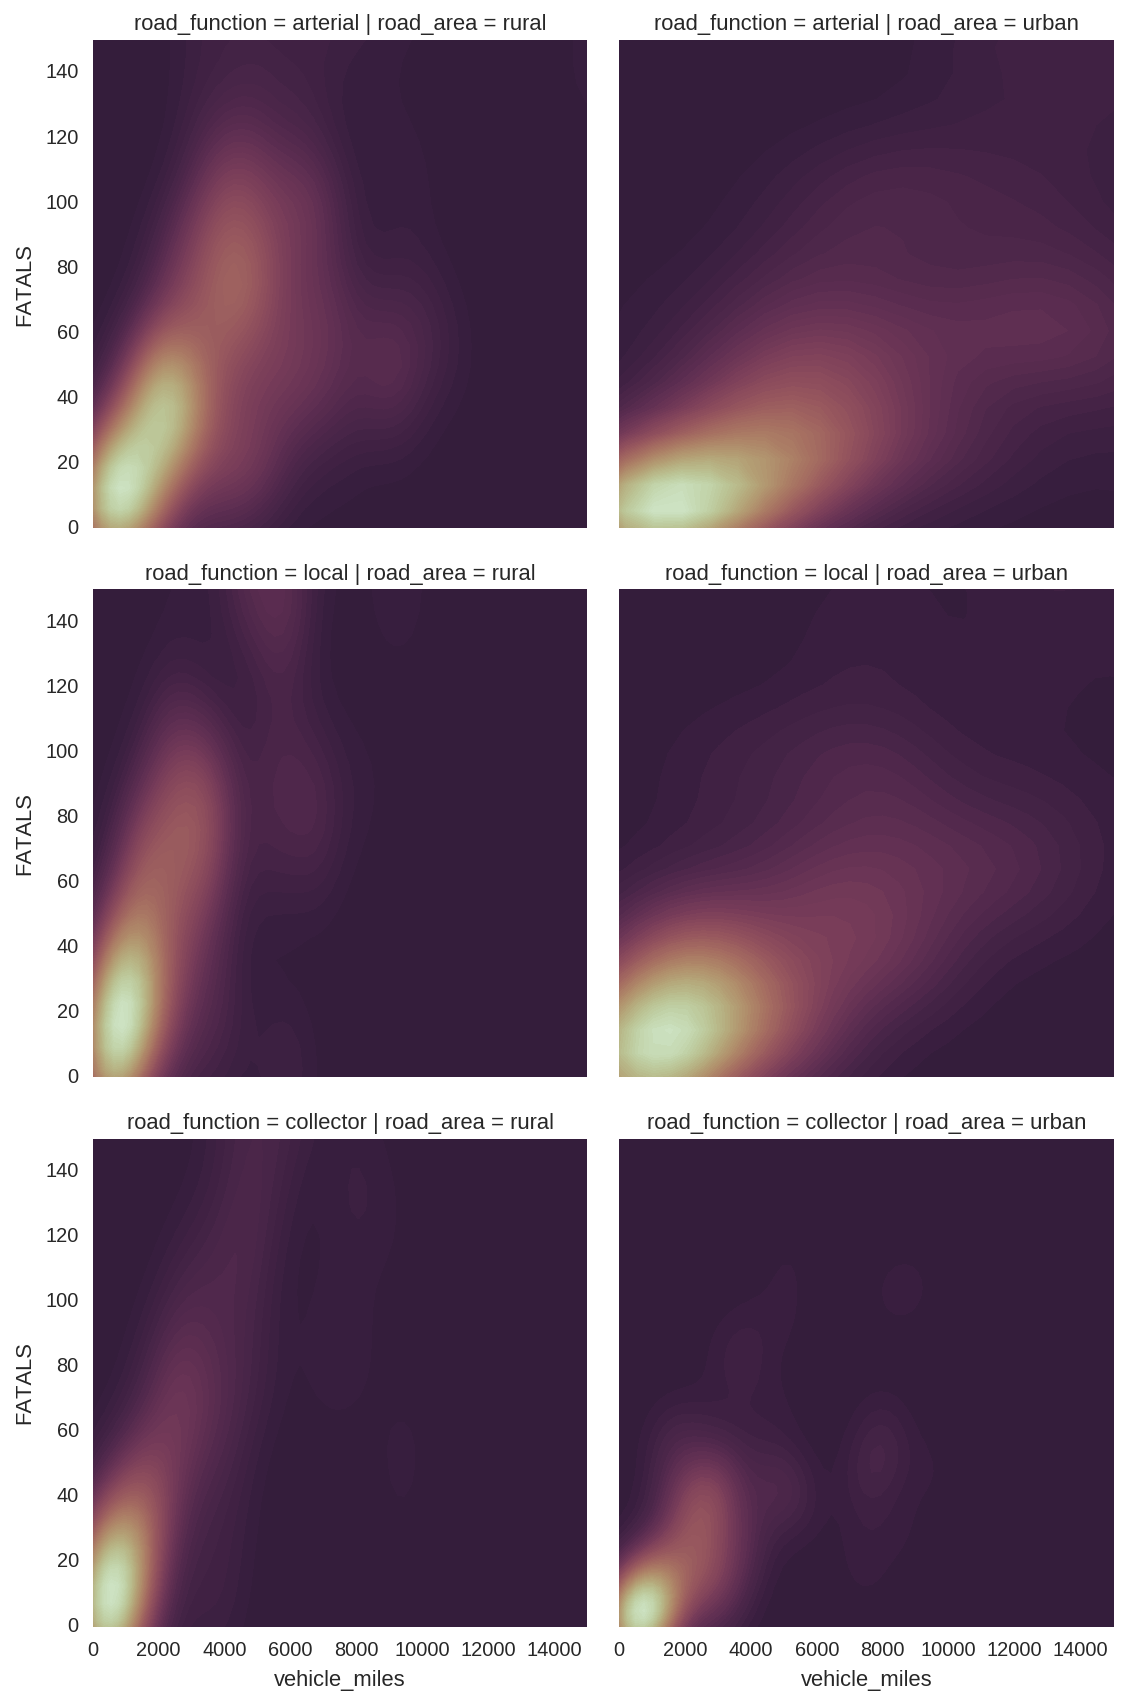

In [257]:
with sns.axes_style("dark"):
    g = sns.FacetGrid(data=accidents_by_vm,
                      row='road_function',
                      col='road_area',
                      size=4)
g.set(xlim=(0,15000), ylim=(0,150))
g.map(sns.kdeplot, 
      "vehicle_miles", 
      "FATALS",
      cmap=kde_cmap,
      n_levels=75,
      shade=True)

/opt/conda/lib/python2.7/site-packages/numpy/lib/function_base.py:3558: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


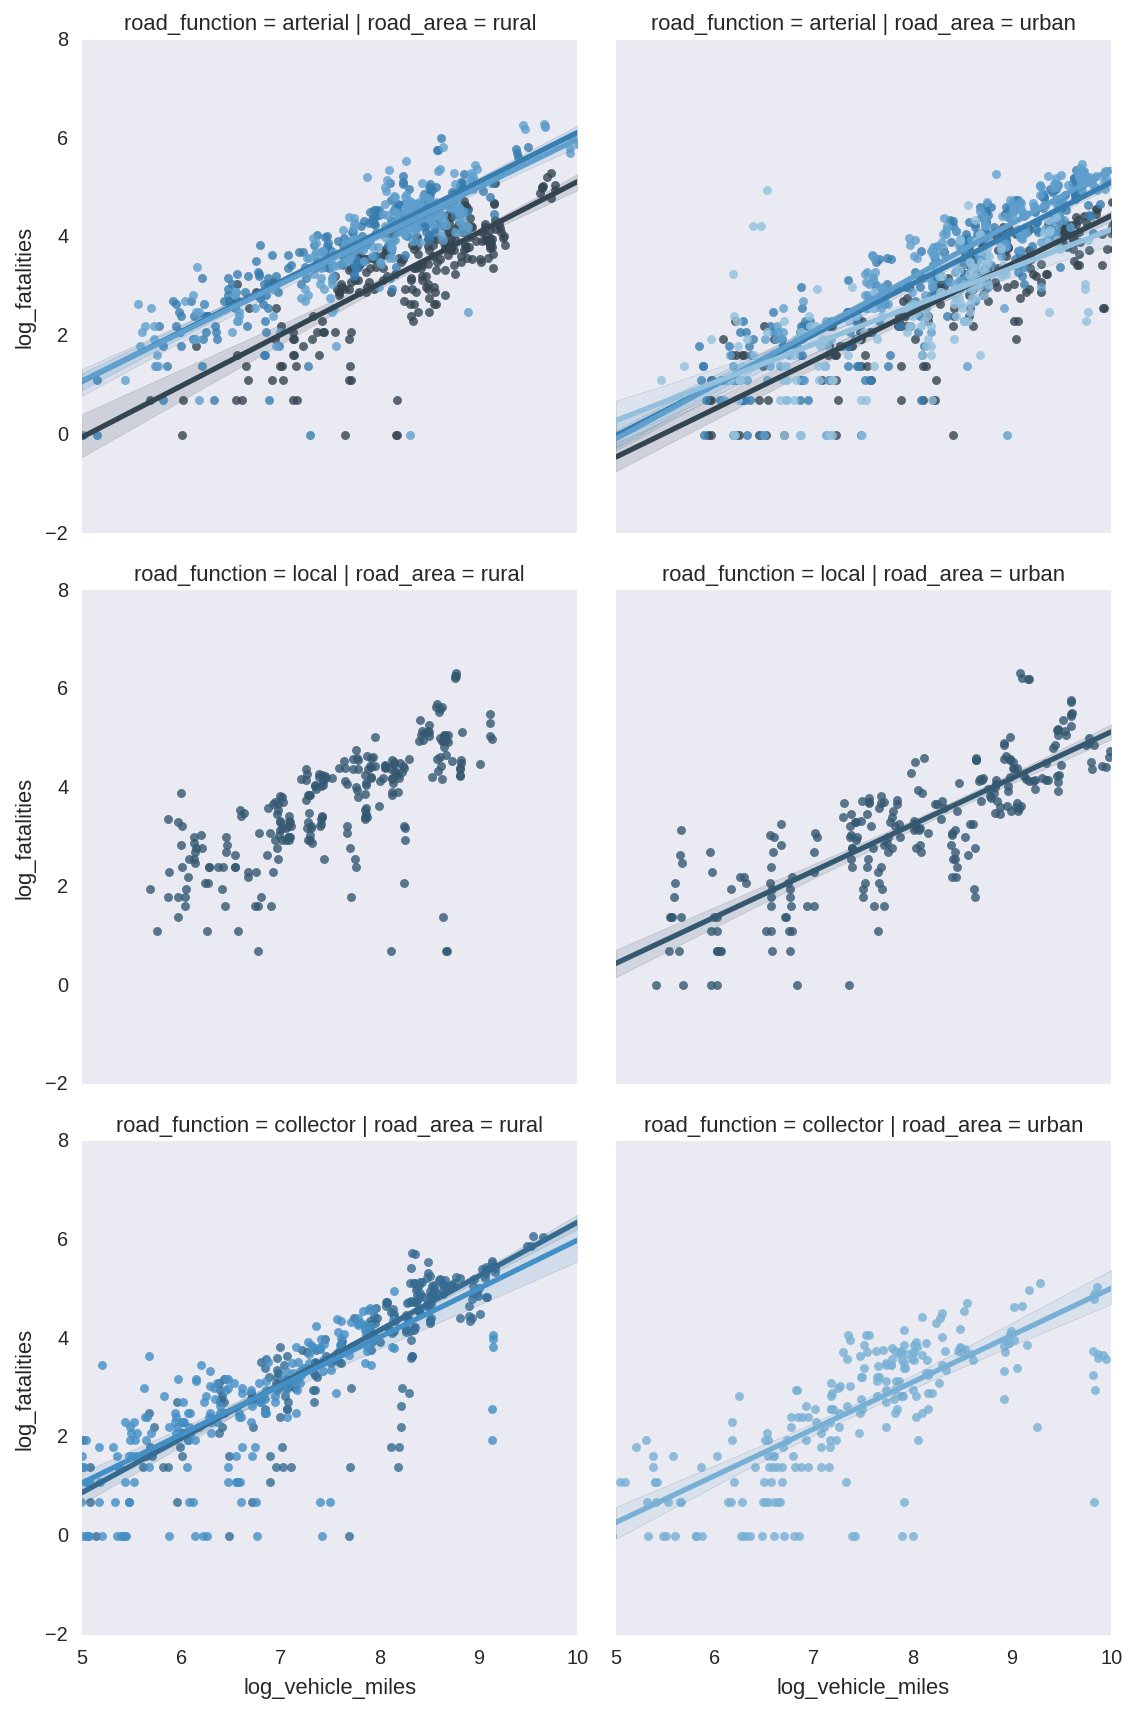

In [299]:
with sns.axes_style("dark"):
    g = sns.FacetGrid(data=accidents_by_vm,
                      row='road_function',
                      col='road_area',
                      hue='road_function_xref',
                      palette="Blues_d",
                      size=4)
#g.set(xlim=(0,15000), ylim=(0,7))
g.map(sns.regplot, 
      'log_vehicle_miles', 
      'log_fatalities',
     robust=True)

## Prediction

### Classes

In [ ]:
"""class CreateDicts(sk.base.BaseEstimator, sk.base.TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.dict_list = []
        for x_item in X:
            item_dict = {}
            if isinstance(x_item, basestring):
                item_dict[x_item] = 1
            else:
                for item_list in x_item:
                    item_dict[item_list] = 1
            self.dict_list.append(item_dict)
        return self.dict_list """

#### `ModelTransformer`()

In [ ]:
class ModelTransformer(sk.base.BaseEstimator, sk.base.TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict(X))

In [302]:
glm_poisson = sm.GLM(accidents_by_vm['FATALS'], accidents_by_vm['vehicle_miles'], family=sm.families.Poisson())
poisson = glm_poisson.fit()

In [304]:
print poisson.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 FATALS   No. Observations:                 2783
Model:                            GLM   Df Residuals:                     2782
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -4.0605e+05
Date:                Sat, 13 Aug 2016   Deviance:                   1.0468e+06
Time:                        11:16:21   Pearson chi2:                 7.09e+06
No. Iterations:                    16                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
vehicle_miles     0.0001   9.28e-08   1252.909      0.000         0.000     0.000


In [420]:
rate_coef = poisson.params[0]

In [417]:
exposure_data = np.linspace(1,15000,150)
fatality_data = range(0,150)
len(fatality_data)
exposure_rep = []
exposure_rep += [[e]*len(fatality_data) for e in exposure_data]
exposures = [item for sublist in exposure_rep for item in sublist]

In [418]:
miles = 1000
counts = ((miles*rate_coef)**fatality_data)*np.exp(-1*miles*rate_coef)/scipy.misc.factorial(fatality_data)
dist_1000 = pd.DataFrame({'fatalities': fatality_data,
                           'counts': counts})

In [395]:
fatalities = fatality_data * len(exposure_data)

In [396]:
poisson_view = pd.DataFrame({'vehicle_miles': exposures,
                             'fatalities': fatalities})

In [397]:
type(poisson_view.vehicle_miles[9])

numpy.float64

In [398]:
poisson_view['counts'] = (poisson_view['vehicle_miles']*rate_coef)**poisson_view['fatalities'] *\
                          np.exp(-1*poisson_view['vehicle_miles']*rate_coef)/\
                          scipy.misc.factorial(poisson_view['fatalities'])

In [399]:
poisson_view.head()

,fatalities,vehicle_miles,counts
0,0,1.0,9.998837e-01
1,1,1.0,1.162644e-04
2,2,1.0,6.759491e-09
3,3,1.0,2.619932e-13
4,4,1.0,7.616006e-18


[(0, 20)]

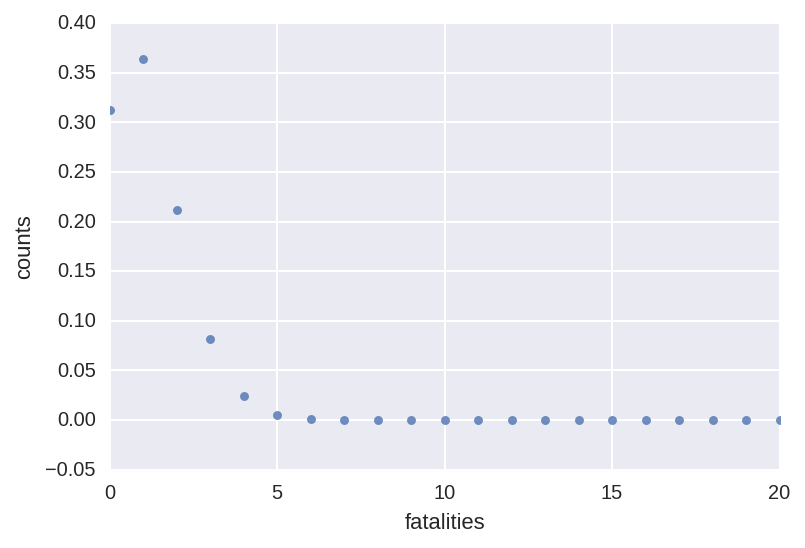

In [421]:
p = sns.regplot(data=dist_10000,
            x='fatalities', 
            y='counts',
            fit_reg = False,
            scatter=True)
p.set(xlim=(0,20))

## Appendix

`----------------------------------------------------------------------`

### Displayed data

#### Vehicle miles and registration data
Directory of .XLS and .XLSX Excel files exported from US Department of Transportation

In [917]:
excels

,filename,year,source_table,description,full_path
0,vehicle_reg_by_state_mv1_2014.xlsx,2014,mv1,vehicle_reg_by_state,/home/vagrant/fars/data/xlsx/vehicle_reg_by_st...
1,vehicle_miles_distribution_vm4_2010.xls,2010,vm4,vehicle_miles_distribution,/home/vagrant/fars/data/xlsx/vehicle_miles_dis...
2,lane_length_by_function_hm60_2013.xls,2013,hm60,lane_length_by_function,/home/vagrant/fars/data/xlsx/lane_length_by_fu...
3,vehicle_reg_by_state_mv1_2011.xlsx,2011,mv1,vehicle_reg_by_state,/home/vagrant/fars/data/xlsx/vehicle_reg_by_st...
4,vehicle_miles_by_function_vm2_2010.xls,2010,vm2,vehicle_miles_by_function,/home/vagrant/fars/data/xlsx/vehicle_miles_by_...
5,vehicle_miles_by_function_vm2_2011.xls,2011,vm2,vehicle_miles_by_function,/home/vagrant/fars/data/xlsx/vehicle_miles_by_...
6,road_miles_by_function_hm20_2010.xls,2010,hm20,road_miles_by_function,/home/vagrant/fars/data/xlsx/road_miles_by_fun...
7,vehicle_miles_by_function_hm44_2012.xls,2012,hm44,vehicle_miles_by_function,/home/vagrant/fars/data/xlsx/vehicle_miles_by_...
8,road_miles_by_function_hm20_2011.xls,2011,hm20,road_miles_by_function,/home/vagrant/fars/data/xlsx/road_miles_by_fun...
9,lane_length_by_function_hm60_2011.xls,2011,hm60,lane_length_by_function,/home/vagrant/fars/data/xlsx/lane_length_by_fu...


In [916]:
excel_dict

{'hm20':    FILE_YEAR            Unnamed: 0 Unnamed: 1 Unnamed: 10 Unnamed: 11  \
 0       2013               Alabama    610.341      42.147     1164.94   
 1       2013                Alaska    1023.93           0     131.242   
 2       2013               Arizona     920.96     207.928     1491.12   
 3       2013              Arkansas     383.38      132.97      770.95   
 4       2013            California    1207.48     1471.59      7041.8   
 5       2013              Colorado    684.474     313.031      1021.7   
 6       2013           Connecticut      43.28      239.79      689.44   
 7       2013              Delaware          0       30.38       175.6   
 8       2013  District of Columbia          0      15.856     106.574   
 9       2013               Florida    748.448     571.161     3608.18   
 10      2013               Georgia     535.85      148.95     2308.91   
 11      2013                Hawaii          0       33.65     276.824   
 12      2013                 

In [1388]:
set(accidents_vm2['state'])

{nan,
 'Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming'}

In [1375]:
vm2.iloc[2:3,0].index

MultiIndex(levels=[[u'Alabama', u'Alaska', u'Arizona', u'Arkansas', u'California', u'Colorado', u'Connecticut', u'Delaware', u'Dist. of Columbia', u'Florida', u'Georgia', u'Hawaii', u'Idaho', u'Illinois', u'Indiana', u'Iowa', u'Kansas', u'Kentucky', u'Louisiana', u'Maine', u'Maryland', u'Massachusetts', u'Michigan', u'Minnesota', u'Mississippi', u'Missouri', u'Montana', u'Nebraska', u'Nevada', u'New Hampshire', u'New Jersey', u'New Mexico', u'New York', u'North Carolina', u'North Dakota', u'Ohio', u'Oklahoma', u'Oregon', u'Pennsylvania', u'Puerto Rico', u'Puerto Rico  (2)', u'Puerto Rico  2/', u'Rhode Island', u'South Carolina', u'South Dakota', u'Tennessee', u'Texas', u'Texas (2)', u'Utah', u'Vermont', u'Virginia', u'Washington', u'West Virginia', u'Wisconsin', u'Wyoming'], [2010, 2011, 2012, 2013, 2014], [u'rural', u'urban'], [u'collector', u'freeway_or_expressway', u'interstate', u'local', u'major_collector', u'minor_arterial', u'other_principal_arterial']],
           labels=[[0], 

In [1385]:
vm2

,state,year,road_area,road_function_xref,vehicle_miles
0,Alabama,2010,rural,collector,1685.570000
1,Alabama,2010,rural,freeway_or_expressway,0.000000
2,Alabama,2010,rural,interstate,5744.605837
3,Alabama,2010,rural,local,6851.415000
4,Alabama,2010,rural,major_collector,4983.954972
5,Alabama,2010,rural,minor_arterial,4800.226643
6,Alabama,2010,rural,other_principal_arterial,6503.179197
7,Alabama,2010,urban,collector,3273.775149
8,Alabama,2010,urban,freeway_or_expressway,591.210765
9,Alabama,2010,urban,interstate,7552.172521


In [1247]:
roads

,road_fnc,road_function_full,road_area,road_function_only
0,1,Rural-Principal Arterial-Interstate,rural,interstate
1,2,Rural-Principal Arterial-Other,rural,other_principal_arterial
2,3,Rural-Minor Arterial,rural,minor_arterial
3,4,Rural-Major Collector,rural,major_collector
4,5,Rural-Minor Collector,rural,minor_collector
5,6,Rural-Local Road or Street,rural,local
6,9,Rural-Unknown Rural,rural,unknown
7,11,Urban-Principal Arterial-Interstate,urban,interstate
8,12,Urban-Principal Arterial-Other Freeways or Exp...,urban,freeway_or_expressway
9,13,Urban-Other Principal Arterial,urban,other_principal_arterial


In [132]:
accidents_by_vm.head()

,YEAR,state,road_area,road_function_xref,vehicle_miles,FATALS
0,2010,Alabama,rural,interstate,5744.605837,50.0
1,2010,Alabama,rural,local,6851.415000,168.0
2,2010,Alabama,rural,major_collector,4983.954972,78.0
3,2010,Alabama,rural,minor_arterial,4800.226643,74.0
4,2010,Alabama,rural,minor_collector,1685.570000,35.0


In [90]:
road_function_groups

,road_function,road_function_xref
0,collector,major_collector
1,arterial,freeway_or_expressway
2,arterial,other_principal_arterial
3,collector,collector
4,collector,minor_collector
5,arterial,minor_arterial
6,local,local
7,arterial,interstate


In [269]:
accidents_by_vm

,YEAR,state,road_area,road_function_xref,vehicle_miles,FATALS,rate,road_function,log_vehicle_miles,log_fatalities
0,2010,Alabama,rural,interstate,5744.605837,50.0,0.008704,arterial,8.656017,3.912023
1,2010,Alabama,urban,interstate,7552.172521,41.0,0.005429,arterial,8.929591,3.713572
2,2010,Alaska,rural,interstate,858.995539,18.0,0.020955,arterial,6.755764,2.890372
3,2010,Alaska,urban,interstate,663.146376,9.0,0.013572,arterial,6.496996,2.197225
4,2010,Arizona,rural,interstate,7132.905012,103.0,0.014440,arterial,8.872474,4.634729
5,2010,Arizona,urban,interstate,6064.827159,45.0,0.007420,arterial,8.710261,3.806662
6,2010,Arkansas,rural,interstate,4328.487400,52.0,0.012013,arterial,8.372973,3.951244
7,2010,Arkansas,urban,interstate,4092.658531,20.0,0.004887,arterial,8.316950,2.995732
8,2010,California,rural,interstate,17565.014236,158.0,0.008995,arterial,9.773664,5.062595
9,2010,California,urban,interstate,68206.775561,235.0,0.003445,arterial,11.130299,5.459586


### Save data

In [59]:
with open('data/lat_long.csv', 'w') as ll:
    accidents.to_csv(ll, columns=('LATITUDE', 'LONGITUD'))